# 3. Tutorial: Create iML1515 GECKO model with predicted turnover numbers

An initial GECKO model of iML1515 was created, with default values primarily being used to expedite the model creation process. In the preceding tutorial, enzyme-related parameters, particularly those associated with transporters, were modified, leading to enhanced protein predictions. However, this necessitated a more profound comprehension of the organism and its modeling. In this tutorial, we will employ a semi-automated procedure to substitute the default turnover numbers for metabolic reactions with those predicted via the TurNuP web portal (https://turnup.cs.hhu.de/Kcat). It should be noted that the interface to the TurNuP web portal may undergo changes in the future, which would require an update to the procedure given below.

As was previously established, coupling constraints are critical to GECKO insofar as they couple reaction fluxes with protein requirements. The turnover numbers are important parameters of these coupling constraints. Up to this point, a default value for the turnover numbers has been used for metabolic reactions. It is important to note that turnover numbers can span a range of several orders of magnitude, and in databases such as Brenda, measured values for turnover numbers of metabolic reactions can be found. However, this covers only a small percentage of reactions, even for a model organism like *E. coli*. It is noteworthy that the values obtained for turnover numbers can vary significantly between different laboratories. This variability underscores the challenges associated with accurately measuring turnover numbers (Bisswanger, 2014). Furthermore, in vitro reactions may not accurately reflect the complex in vivo conditions, highlighting the need for more precise and comprehensive experimental methods to determine turnover numbers. 

TurNuP (Kroll et al., 2023) is a general and organism-independent model that predicts turnover numbers for natural reactions of wild-type enzymes. This prediction is based on provided protein sequence and metabolite references. TurNuP has been trained on turnover numbers extracted from online databases like Brenda. The average deviation of predictions to measured values has been determined to be 4.8-fold. While the predicted turnover numbers might not be entirely accurate, it is hypothesized that they can provide a relative difference within the reaction network, which is more realistic than using a single default value. GECKO and RBA models do not model detailed enzyme saturation levels per reaction. However, it is possible to modulate the turnover numbers to implicitly model a per reaction saturation level, averaged across conditions.

Peter Schubert, Heinrich-Heine University Duesseldorf, Institute for Computational Cell Biology (Prof. Dr. M. Lercher), January, 2025

## Step 1: Initial setup

In [1]:
# Required imports and model names
import os
import re
import pandas as pd
import cobra

from f2xba import XbaModel, EcModel
from f2xba import EcmOptimization, EcmResults
from f2xba.utils.mapping_utils import load_parameter_file, write_parameter_file

fba_model = 'iML1515'
baseline_model = 'iML1515_modified_GECKO'
target_model = 'iML1515_predicted_GECKO'
reference_cond = 'Glucose'

# Create media conditions
media_grs = {'Acetate': ['ac', 0.29], 'Glycerol': ['glyc', 0.47], 'Fructose': ['fru', 0.54], 
             'L-Malate': ['mal__L', 0.55], 'Glucose': ['glc__D', 0.66], 'Glucose 6-Phosphate': ['g6p', 0.78]}
base_medium = ['ca2', 'cbl1', 'cl', 'co2', 'cobalt2', 'cu2', 'fe2', 'fe3', 'h2o', 'h', 'k', 'mg2', 
               'mn2', 'mobd', 'na1', 'nh4', 'ni2', 'o2', 'pi', 'sel', 'slnt', 'so4', 'tungs', 'zn2']
conditions = {}
exp_grs = {}
for cond, (carbon_sid, exp_gr )in media_grs.items():
    conditions[cond] = {f'EX_{sidx}_e': 1000.0 for sidx in base_medium}
    conditions[cond][f'EX_{carbon_sid}_e'] = 1000.0
    exp_grs[cond] = exp_gr
print(f'{len(conditions)} minimal media conditions created for simulation')

# Load proteomics
fname = os.path.join('data', 'Ecoli_Schmidt_proteomics.xlsx')
with pd.ExcelFile(fname) as xlsx:
    df_mpmf = pd.read_excel(xlsx, sheet_name='proteomics', index_col=0)
    print(f'{len(df_mpmf)} records of proteomics loaded from {fname}')
min_confidence_level = 43.0
df_mpmf = df_mpmf[df_mpmf['confidence'] > min_confidence_level]
print(f'{len(df_mpmf)} records with confidence level above {min_confidence_level}')

6 minimal media conditions created for simulation
2347 records of proteomics loaded from data/Ecoli_Schmidt_proteomics.xlsx
2232 records with confidence level above 43.0


## Step 2: Predict turnover values using TurNuP

The TurNuP web portal, developed by the Institute of Computational Cell Biology at Heinrich-Heine-University Düsseldorf, Germany, facilitates the prediction of turnover numbers (kcat values) for metabolic enzyme-catalyzed reactions. The file-based interface supports the upload and download of up to 500 entries in '.xlsx' files. The replacement of manual turnover numbers with predicted values is outlined below.

### 2.1: create input files for TurNuP

The TurNuP web portal requires three pieces of information to be entered into its input records: the amino acid sequence, and, when available, the KEGG compound identifiers for substrates and products. It should be noted that only input records for forward directions are necessary, as TurNuP predicts the same turnover number for forward and reverse directions. Files that are uploaded and downloaded will be placed in the `.\tmp` directory. An XbaModel instance is then created using the XBA configuration of the baseline model. Subsequently, the method `xba_model.generate_turnup_input()` is invoked to generate the input files, each comprising up to 500 records.

Implementation details: ‘xba_model.generate_turnup_input()’ extracts the turnover numbers for metabolic reactions that have been utilized for the baseline model and generates TurNuP input records. For homomeric enzymes, the amino acid sequence of the protein is used; for heteromeric enzymes, the protein sequences are concatenated. KEGG compound identifiers for substrates and products are extracted from the species annotation data of the foundational GEM. In the event that no KEGG identifier has been defined, the respective input field is left empty and the metabolite identifier is returned. This approach enables the manual mapping of such metabolite identifiers to KEGG, InChi, or Smiles references using a Python dictionary. This dictionary can then be provided as an optional parameter, termed "mids2ref," to the ‘xba_model.generate_turnup_input()’ function.

In [2]:
# generate TurNuP input files

# delete previously generated input and output files
for file in os.listdir('tmp'):
    if re.match('.*_output.xlsx', file) or re.match('tmp_turnup_input.*.xlsx', file):
        os.remove(os.path.join('tmp', file))

# Create an instance of XbaModel
xba_model = XbaModel(os.path.join('SBML_models', f'{fba_model}.xml'))
xba_model.configure(os.path.join('data', f'{baseline_model}_xba_parameters.xlsx'))

kcats_fname = os.path.join('data', f'{baseline_model}_kcats.xlsx')
mids_no_ref = xba_model.generate_turnup_input(kcats_fname, input_basename=os.path.join('tmp', 'tmp_turnup_input'))

loading: SBML_models/iML1515.xml (last modified: Thu Dec  5 10:03:46 2024)
3 table(s) with parameters loaded from data/iML1515_modified_GECKO_xba_parameters.xlsx (Thu Mar 20 20:49:15 2025)
   2 attributes on reaction instances updated
  22 gene product(s) removed from reactions (1494 gene products remaining)
extracting UniProt protein data from data/uniprot_organism_83333.tsv
1494 proteins created
1203 enzymes added with default stoichiometry
1 table(s) with parameters loaded from data/iML1515_enzyme_composition_updated.xlsx (Thu Mar 20 20:48:35 2025)
1203 enzyme compositions updated from data/iML1515_enzyme_composition_updated.xlsx
2221 reactions catalyzed by 1203 enzymes
default kcat values configured for ['metabolic', 'transporter'] reactions
1 table(s) with parameters loaded from data/iML1515_modified_GECKO_kcats.xlsx (Thu Mar 20 20:48:35 2025)
5357 kcat values updated from data/iML1515_modified_GECKO_kcats.xlsx
   0 enzymes removed due to missing kcat values
1877 constraints (+0);

### 2.2: upload input files to TurNuP web portal

All input files must be uploaded to the TurNuP web portal using a web browser. To access the TurNuP web portal, navigate to https://turnup.cs.hhu.de/Kcat_multiple_input. Within the designated page titled `kcat Prediction - Multiple Input`, select the `Choose File` option and navigate to the ‘.\tmp’ directory to select an input file, such as ‘tmp_turnup_input_1_seq.xlsx’. Submit the file by pressing the `Submit` button. This action will redirect to a new page titled ‘Job Status’, accompanied by a `Download Link`. It is imperative to note that initially, this link will not result in any changes to the page; it is essential that the page remains open until the input file has been successfully processed. That is to say, the download link will redirect to a page where the output file can be downloaded. These steps must be repeated for each input file that has been created, resulting in multiple open sessions to the portal.


### 2.3: download output files from TurNuP

The processing of all input files can require up to one hour. It is therefore advisable to periodically access the download links. Upon completion of a job, a new page will be displayed, bearing the title `Your job calculation is finished`. Select `Download` in order to obtain the output file. Subsequently, the page can be closed. The process should be repeated until all output files have been downloaded. Finally, the output files must be copied to the `.\tmp` directory.

### 2.4: update turnover numbers

During the generation of input files, information columns were incorporated, which are subsequently transferred to the output files and can be utilized as keys. The predicted turnover numbers contained within the downloaded output files will replace the turnover numbers of the baseline model.

In [3]:
# update turnover numbers

# process TurNuP output files
pred_kcats = {}
for file in os.listdir('tmp'):
    if re.match('.*_output.xlsx', file):
        with pd.ExcelFile(os.path.join('tmp', file)) as xlsx:
            df_pred_kcats = pd.read_excel(xlsx)
        for _, row in df_pred_kcats.iterrows():
            if type(row['fwd_key']) is str:
                pred_kcats[row['fwd_key']] = row['kcat [s^(-1)]']
            if type(row['rev_key']) is str:
                pred_kcats[row['rev_key']] = row['kcat [s^(-1)]']
                
# create updated kcats file
df_kcats = load_parameter_file(os.path.join('data', f'{baseline_model}_kcats.xlsx'))['kcats']
count = 0
for key in df_kcats.index:
    if key in pred_kcats:
        df_kcats.at[key, 'kcat_per_s'] = pred_kcats[key]
        df_kcats.at[key, 'notes'] = f'TurNuP predicted'
        count += 1
print(f'{count} predicted kcat values added')
write_parameter_file(os.path.join('data', f'{target_model}_kcats.xlsx'), {'kcats': df_kcats})

1 table(s) with parameters loaded from data/iML1515_modified_GECKO_kcats.xlsx (Thu Mar 20 20:48:35 2025)
2349 predicted kcat values added
1 table(s) with parameters written to  data/iML1515_predicted_GECKO_kcats.xlsx


## Step 3: Create XBA and ECM configuration files

The parameter `kcats_fname` in the XBA configuration file is updated, and the parameter `avg_enz_sat` in the ECM configuration file is adjusted.

In [4]:
# Create updated XBA parameter
xba_params = load_parameter_file(os.path.join('data', f'{baseline_model}_xba_parameters.xlsx'))
xba_params['general'].at['kcats_fname', 'value'] = os.path.join('data', f'{target_model}_kcats.xlsx')
write_parameter_file(os.path.join('data', f'{target_model}_xba_parameters.xlsx'), xba_params)

# Create updated ECM parameter file
ecm_params = load_parameter_file(os.path.join('data', f'{baseline_model}_ecm_parameters.xlsx'))
ecm_params['general'].at['avg_enz_sat', 'value'] = 0.64
write_parameter_file(os.path.join('data', f'{target_model}_ecm_parameters.xlsx'), ecm_params)

3 table(s) with parameters loaded from data/iML1515_modified_GECKO_xba_parameters.xlsx (Thu Mar 20 20:49:15 2025)
3 table(s) with parameters written to  data/iML1515_predicted_GECKO_xba_parameters.xlsx
1 table(s) with parameters loaded from data/iML1515_modified_GECKO_ecm_parameters.xlsx (Thu Mar 20 20:49:15 2025)
1 table(s) with parameters written to  data/iML1515_predicted_GECKO_ecm_parameters.xlsx


## Step 4: Create GECKO model

In [5]:
# Create GECKO model
xba_model = XbaModel(os.path.join('SBML_models', f'{fba_model}.xml'))
xba_model.configure(os.path.join('data', f'{target_model}_xba_parameters.xlsx'))

ec_model = EcModel(xba_model)
ec_model.configure(os.path.join('data', f'{target_model}_ecm_parameters.xlsx'))
ec_model.export(os.path.join('SBML_models', f'{target_model}.xml'))

loading: SBML_models/iML1515.xml (last modified: Thu Dec  5 10:03:46 2024)
3 table(s) with parameters loaded from data/iML1515_predicted_GECKO_xba_parameters.xlsx (Thu Mar 20 20:53:30 2025)
   2 attributes on reaction instances updated
  22 gene product(s) removed from reactions (1494 gene products remaining)
extracting UniProt protein data from data/uniprot_organism_83333.tsv
1494 proteins created
1203 enzymes added with default stoichiometry
1 table(s) with parameters loaded from data/iML1515_enzyme_composition_updated.xlsx (Thu Mar 20 20:48:35 2025)
1203 enzyme compositions updated from data/iML1515_enzyme_composition_updated.xlsx
2221 reactions catalyzed by 1203 enzymes
default kcat values configured for ['metabolic', 'transporter'] reactions
1 table(s) with parameters loaded from data/iML1515_predicted_GECKO_kcats.xlsx (Thu Mar 20 20:53:26 2025)
5357 kcat values updated from data/iML1515_predicted_GECKO_kcats.xlsx
   0 enzymes removed due to missing kcat values
1877 constraints (+

True

---
---
## Step 5: Load and optimize GECKO model (cobrapy)

In [6]:
# Load model using cobrapy
fname = os.path.join('SBML_models', f'{target_model}.xml')
ecm = cobra.io.read_sbml_model(fname)
total_protein = ecm.reactions.get_by_id('V_PC_total').upper_bound

eo = EcmOptimization(fname, ecm)
sigma = eo.avg_enz_saturation
print(f'total modeled protein: {total_protein:.2f} mg/gDW, average saturation level: {sigma}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-22
SBML model loaded by sbmlxdf: SBML_models/iML1515_predicted_GECKO.xml (Thu Mar 20 20:53:54 2025)
total modeled protein: 306.59 mg/gDW, average saturation level: 0.64


Acetate                  : pred gr: 0.439 h-1 vs. exp 0.290, diff:  0.149
Glycerol                 : pred gr: 0.669 h-1 vs. exp 0.470, diff:  0.199
Fructose                 : pred gr: 0.625 h-1 vs. exp 0.540, diff:  0.085
L-Malate                 : pred gr: 0.738 h-1 vs. exp 0.550, diff:  0.188
Glucose                  : pred gr: 0.658 h-1 vs. exp 0.660, diff: -0.002
Glucose 6-Phosphate      : pred gr: 0.735 h-1 vs. exp 0.780, diff: -0.045


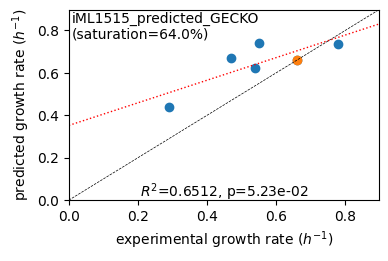

Protein mass fractions:
Acetate                  : r² = 0.0335, p = 5.77e-09 ( 999 proteins lin scale)
Glycerol                 : r² = 0.0393, p = 2.64e-10 ( 999 proteins lin scale)
Fructose                 : r² = 0.0973, p = 5.46e-24 ( 999 proteins lin scale)
Glucose                  : r² = 0.0733, p = 3.07e-18 ( 999 proteins lin scale)
Acetate                  : r² = 0.2763, p = 3.27e-23 ( 307 proteins log scale)
Glycerol                 : r² = 0.2500, p = 9.31e-21 ( 306 proteins log scale)
Fructose                 : r² = 0.2748, p = 2.69e-22 ( 296 proteins log scale)
Glucose                  : r² = 0.2841, p = 7.38e-24 ( 306 proteins log scale)

condition: Glucose
1494 proteins in model with total predicted mass fraction of 537.9 mg/gP
      999 have been measured with mpmf of  514.4 mg/gP vs. 471.4 mg/gP predicted
           762 metabolic proteins measured 414.0 mg/gP vs. 308.0 mg/gP predicted
           237 transport proteins measured 100.4 mg/gP vs. 163.3 mg/gP predicted
      49

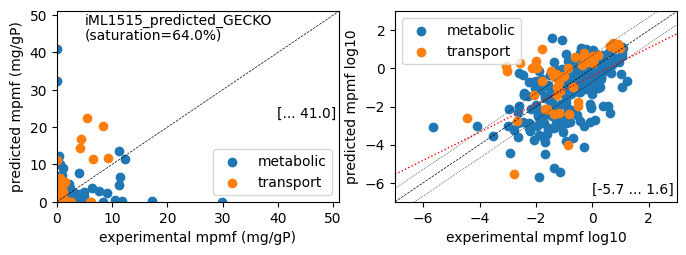

1 file(s) exported for "Load reaction data" into Escher maps


In [7]:
# Optimize model using cobrapy and analyze results
pred_results = {}
for cond, medium in conditions.items():
    ecm.medium = medium 
    solution = ecm.optimize()
    if solution.status == 'optimal':
        gr = solution.objective_value
        pred_results[cond] = solution
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
              f'diff: {gr - exp_grs[cond]:6.3f}')
    else:    
        print(f'{cond} ended with status {solution.status}')

# Analyze results
er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight='Glucose')

print(f'Protein mass fractions:')
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')
print()
er.report_protein_levels('Glucose')
er.plot_proteins('Glucose', plot_fname=os.path.join('plots', f'{target_model}_proteins_Glucose.pdf'))  
er.save_to_escher(df_net_fluxes['Glucose'], os.path.join('escher', target_model))

## (Optional) Track progress

In [8]:
import scipy
import numpy as np

number = 3
xy = np.array([[df_mpmf.at[gene, reference_cond], df_proteins.at[gene, reference_cond]] 
                for gene in df_proteins.index if gene in df_mpmf.index])
log10_x, log10_y = er.get_log10_xy(xy)
lin_pearson_r, _ = scipy.stats.pearsonr(xy[:, 0], xy[:, 1])
log_pearson_r, _ = scipy.stats.pearsonr(log10_x, log10_y)

predictions = load_parameter_file('protein_predictions.xlsx')
data = [[number, target_model, lin_pearson_r**2,log_pearson_r**2, len(xy), len(log10_x)]]
cols = ['No', 'model', 'lin r2', 'log r2', 'lin proteins', 'log proteins']
df = pd.DataFrame(data, columns=cols).set_index('No')
if number in predictions[reference_cond].index:
    predictions[reference_cond].drop(index=number, inplace=True)
predictions[reference_cond] = pd.concat((predictions[reference_cond], df)).sort_index()
write_parameter_file('protein_predictions.xlsx', predictions)
predictions[reference_cond]

1 table(s) with parameters loaded from protein_predictions.xlsx (Thu Mar 20 20:50:36 2025)
1 table(s) with parameters written to  protein_predictions.xlsx


,model,lin r2,log r2,lin proteins,log proteins
No,,,,,
1,iML1515_default_GECKO,0.033244,0.190225,1018,299
2,iML1515_modified_GECKO,0.135805,0.204476,999,320
3,iML1515_predicted_GECKO,0.073285,0.284092,999,306


## Closing remarks

The process of creating a GECKO model based on turnover numbers predicted by TurNuP is a straightforward one, with the potential to be applied to any organism, provided that KEGG compound identifiers have been configured in the foundational GEM. No organism-specific knowledge is required. However, it should be noted that TurNuP predictions are only applicable to metabolic reactions, as it has not been trained on transporters. The GECKO model has undergone two improvements. Firstly, the required average enzyme saturation level is lower and more realistic, with a decrease from 64% to 80% in the previous model. Secondly, the protein prediction for our reference condition glucose improved when comparing on log scale. However, on the linear protein correlation plot, metabolic proteins are predicted with high level, but zero or now corresponding measurement and vice versa. 

In the next tutorial, we will analyze in more detail predicted flux distributions and protein concentration. Subsequent to this analysis, we will attempt to manually adjust selected turnover numbers to improve protein correlation.

---
---
## (alternatively) Load GECKO model, optimize and analyze (gurobipy)

In [9]:
# Load model using gurobipy
fname = os.path.join('SBML_models', f'{target_model}.xml')
eo = EcmOptimization(fname)
total_protein = eo.get_variable_bounds('V_PC_total')[1]
sigma = eo.avg_enz_saturation
print(f'total modeled protein: {total_protein:.2f} mg/gDW, average saturation level: {sigma}')

SBML model loaded by sbmlxdf: SBML_models/iML1515_predicted_GECKO.xml (Thu Mar 20 20:53:54 2025)
LP Model of iML1515_GECKO
7343 variables, 3372 constraints, 28438 non-zero matrix coefficients
total modeled protein: 306.59 mg/gDW, average saturation level: 0.64


Acetate                  : pred gr: 0.439 h-1 vs. exp 0.290, diff:  0.149
Glycerol                 : pred gr: 0.669 h-1 vs. exp 0.470, diff:  0.199
Fructose                 : pred gr: 0.625 h-1 vs. exp 0.540, diff:  0.085
L-Malate                 : pred gr: 0.738 h-1 vs. exp 0.550, diff:  0.188
Glucose                  : pred gr: 0.658 h-1 vs. exp 0.660, diff: -0.002
Glucose 6-Phosphate      : pred gr: 0.735 h-1 vs. exp 0.780, diff: -0.045


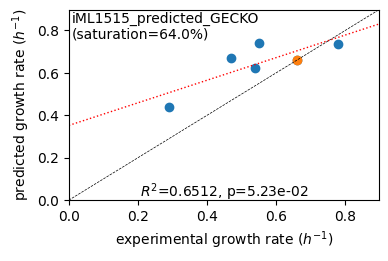

Protein mass fractions:
Acetate                  : r² = 0.0335, p = 5.77e-09 ( 999 proteins lin scale)
Glycerol                 : r² = 0.0393, p = 2.64e-10 ( 999 proteins lin scale)
Fructose                 : r² = 0.0973, p = 5.46e-24 ( 999 proteins lin scale)
Glucose                  : r² = 0.0733, p = 3.07e-18 ( 999 proteins lin scale)
Acetate                  : r² = 0.2763, p = 3.27e-23 ( 307 proteins log scale)
Glycerol                 : r² = 0.2500, p = 9.31e-21 ( 306 proteins log scale)
Fructose                 : r² = 0.2748, p = 2.69e-22 ( 296 proteins log scale)
Glucose                  : r² = 0.2841, p = 7.38e-24 ( 306 proteins log scale)

condition: Glucose
1494 proteins in model with total predicted mass fraction of 537.9 mg/gP
      999 have been measured with mpmf of  514.4 mg/gP vs. 471.4 mg/gP predicted
           762 metabolic proteins measured 414.0 mg/gP vs. 308.0 mg/gP predicted
           237 transport proteins measured 100.4 mg/gP vs. 163.3 mg/gP predicted
      49

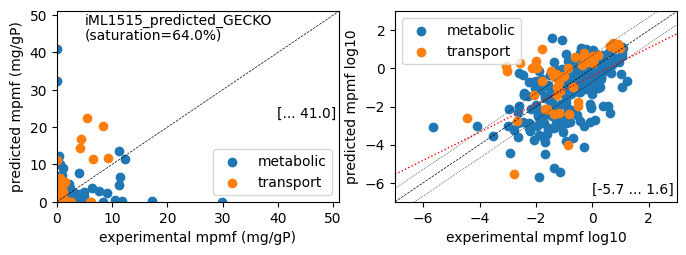

1 file(s) exported for "Load reaction data" into Escher maps


In [10]:
# Optimize model using gurobipy and analyze results
pred_results = {}
for cond, medium in conditions.items():
    eo.set_medium(medium)
    solution = eo.optimize()

    if solution.status == 'optimal':
        pred_results[cond] = solution
        gr = solution.objective_value
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, diff: {gr - exp_grs[cond]:6.3f}')
    else:    
        print(f'{cond} ended with status {solution.status}')
        
# Analyze results
er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight='Glucose')

print(f'Protein mass fractions:')
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')
print()
er.report_protein_levels('Glucose')
er.plot_proteins('Glucose', plot_fname=os.path.join('plots', f'{target_model}_proteins_Glucose.pdf'))  
er.save_to_escher(df_net_fluxes['Glucose'], os.path.join('escher', target_model))

---
---
## References

- Bisswanger, H. (2014). Enzyme assays. Perspectives in Science, 1(1), 41-55. https://doi.org/https://doi.org/10.1016/j.pisc.2014.02.005 
- Kroll, A., Rousset, Y., Hu, X.-P., Liebrand, N. A., & Lercher, M. J. (2023). Turnover number predictions for kinetically uncharacterized enzymes using machine and deep learning. Nature Communications, 14(1), 4139. https://doi.org/10.1038/s41467-023-39840-4 